# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier

In [2]:
data = pd.read_csv("/datasets/users_behavior.csv")
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f645abadf10>,
      dtype=object)

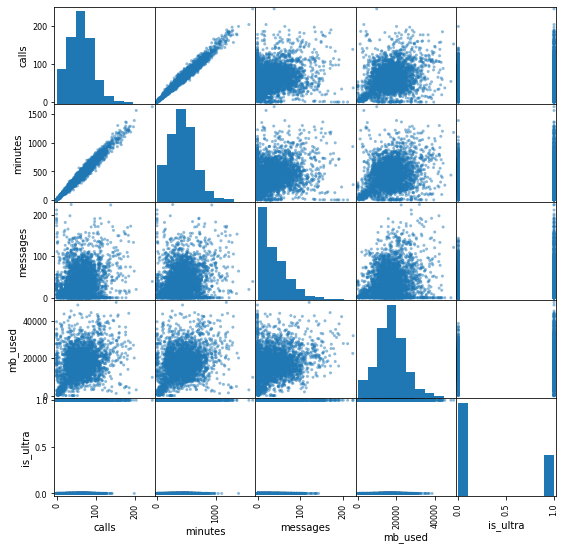

In [5]:
pd.plotting.scatter_matrix(data, figsize = (9,9))

In [6]:
print(data.corr())

             calls   minutes  messages   mb_used  is_ultra
calls     1.000000  0.982083  0.177385  0.286442  0.207122
minutes   0.982083  1.000000  0.173110  0.280967  0.206955
messages  0.177385  0.173110  1.000000  0.195721  0.203830
mb_used   0.286442  0.280967  0.195721  1.000000  0.198568
is_ultra  0.207122  0.206955  0.203830  0.198568  1.000000


In [7]:
data = data.drop('calls', axis = 1)

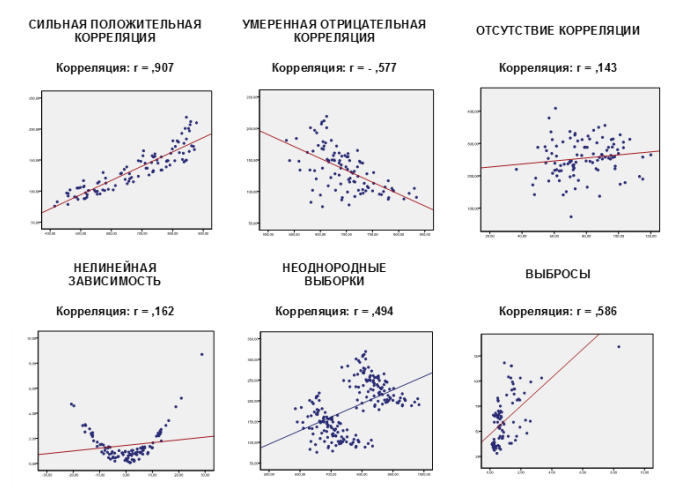

***Вывод***

Итак у нас есть все данные по потребляемому трафику. Обычно люди выбирают тариф исходя из своих потребностей, а это значит, что самые важные значения у нас есть. Можем обучать модели. Нашли сильную зависимость между столбцами 'calls' и 'minutes'. Коэффициент корреляции больше 0.982. Таким образом можем заключить, что эти столбцы мультиколлинеарны. Соответственно удалили столбец со значением количества звонков, так как количество минут - признак, который имеет большую вариативность. Остальные же данные мало зависят друг от друга.

## Разбейте данные на выборки

In [8]:
target = data['is_ultra']
features = data.drop('is_ultra', axis = 1)
features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(
    features, target, test_size=0.4,  random_state=12345) 
features_test, features_valid,  target_test,target_valid  = train_test_split(
    features_valid_and_test, target_valid_and_test, test_size=0.5,  random_state=12345) 
print("Размеры обучающей выборки:", len(features_train), len(target_train))
print("Размеры валидной выборки:", len(features_valid), len(target_valid))
print("Размеры тестовой выборки:", len(features_test), len(target_test))

Размеры обучающей выборки: 1928 1928
Размеры валидной выборки: 643 643
Размеры тестовой выборки: 643 643


Поделили выборку на три части: 60% в обучающей, 20% в валидной и 20% в тестоввой.

## Исследуйте модели

### Наивная байесовская модель

Начинаем проверять модели с наивной байесвоской модели. Также параллельно ищем лучшую модель if блоком при проверке каждой модели.

In [9]:
best_model = None
best_result = 0
model = GaussianNB()
model.fit(features_train, target_train) 
result = model.score(features_valid, target_valid) 
if result > best_result:
        best_model = model 
        best_result = result
print("Accuracy наивной байесовской модели на валидационной выборке:", result)

Accuracy наивной байесовской модели на валидационной выборке: 0.7636080870917574


### Модель случайного леса

Проверяем модели случайного леса, перебирая количество деревьев от 1 до 10.

In [10]:
best_forest_model = None
best_forest_result = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_forest_result:
        best_forest_model = model
        best_forest_result = result
if best_forest_result > best_result:
        best_model = best_forest_model 
        best_result = best_forest_result
print("Accuracy наилучшей модели случайного леса на валидационной выборке:", best_forest_result)

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.7869362363919129


***Вывод***

Модель случайного леса справляется лучше, чем наивная байесовская модель.

### Модель логистической регрессии

Проверим модель логистической регрессии, возможно она не хуже справляется, но обучается намного быстрее.

In [11]:
model = LogisticRegression(solver = "liblinear", random_state = 12345)
model.fit(features_train, target_train) 
result = model.score(features_valid, target_valid) 
if result > best_result:
        best_model = model 
        best_result = result
print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.6982892690513219


***Вывод***

Увы, она хуже :(

### Модель дерева решений

Проверяем модели деревьев решений с разной возможной глубиной.

In [12]:
best_tree_model = None
best_tree_result = 0
for depth in range(1,6):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_tree_result:
        best_tree_model = model
        best_tree_result = result
if best_tree_result > best_result:
        best_model = best_tree_model 
        best_result = best_tree_result
print("Accuracy наилучшей модели древа решений на валидационной выборке:", best_tree_result)

Accuracy наилучшей модели древа решений на валидационной выборке: 0.7884914463452566


***Вывод***

Удивительное рядом. Одно дерево лучше целого леса! Скорее всего нужно было поиграться с подбором глубины этих деревьев, но как факт мы установили значимость гиперпараметров.

### Модель градиентного бустинга

Говорят это стильно, модно, молодёжно, поэтому решил посмотреть, что даст эта модель, хотя пока не разобрался, как градиентный бустинг работает :)

In [13]:
best_boosting_model = None
best_boosting_result = 0
for est in range(1, 15):
    model = GradientBoostingClassifier(random_state=12345, learning_rate = 1, n_estimators=est)
    model.fit(features_train, target_train) 
    result = model.score(features_valid, target_valid) 
    if result > best_boosting_result:
        best_boosting_model = model 
        best_boosting_result = result
if best_boosting_result > best_result:
        best_model = best_boosting_model 
        best_result = best_boosting_result
print("Accuracy наилучшей модели градиентного бустинга на валидационной выборке:", best_boosting_result)        
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Accuracy наилучшей модели градиентного бустинга на валидационной выборке: 0.7884914463452566
Accuracy наилучшей модели на валидационной выборке: 0.7884914463452566


***Вывод***

Модель выиграла по все остальные, причём прилично. Пойду читать, как это работает...

***Вывод2***

## Проверьте модель на тестовой выборке

In [14]:
features_final_train = features_train.append(features_valid, ignore_index = True)
target_final_train = target_train.append(target_valid, ignore_index = True)

In [15]:
best_model.fit(features_final_train, target_final_train)
final_result = best_model.score(features_test, target_test) 
final_forest_result = best_tree_model.score(features_test, target_test)
print("Accuracy наилучшей модели на тестовой выборке:", final_result)
print("Accuracy наилучшей модели на тестовой выборке, если не считать градиентный бустинг:", final_forest_result)

Accuracy наилучшей модели на тестовой выборке: 0.7931570762052877
Accuracy наилучшей модели на тестовой выборке, если не считать градиентный бустинг: 0.7931570762052877


***Вывод***

На тестовой выборке значения лучше, так как мы объеденили тренировочную и валидную выборку, и дообучили модель. Мы получили точность 79,3%, а это на целых 4,3% больше, чем требовалось. Можем считать, что задача выполнена и даже перевыполена. Мы точно можем использовать модель случайного леса, но лучше пойти разобраться с градиентным бустингом и использовать его.

## (бонус) Проверьте модели на адекватность

In [16]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(features_train, target_train) 
dummy_result = dummy_model.score(features_valid, target_valid)
print("Accuracy простой модели на тестовой выборке:", dummy_result)

Accuracy простой модели на тестовой выборке: 0.6842923794712286


***Вывод***

Каждая из наших моделей адекватнее, чем простое присваивание наиболее частого значения. Это довольно хороший знак, так как из скоринга этой модели мы видим, что у нас есть некоторых дисбаланс в данных. Почти что 7 к 3.